# This notebook contains the Stacks parameter tests, final scripts used and analyses to identify sex linked markers for the ddRADseq dataset of <i>Rana macrocnemis</i> 
## Sample set:

Unknown location(s) in Armenia

 - 7 Females
 - 10 males

In [3]:
%matplotlib inline
import os
import Incremental_U as IncU 
import Incremental_C as IncC
import Incremental_Pop_mod as IncPop
import MISC_RAD_tools as MISC
import pprint
import subprocess

In [4]:
%load_ext rpy2.ipython

### Populations command was:

populations -b 1 -P ./ -M sex_info.txt -r 0.75 -p 2 --vcf --min_maf 0.05 > Populations.log 2>&1

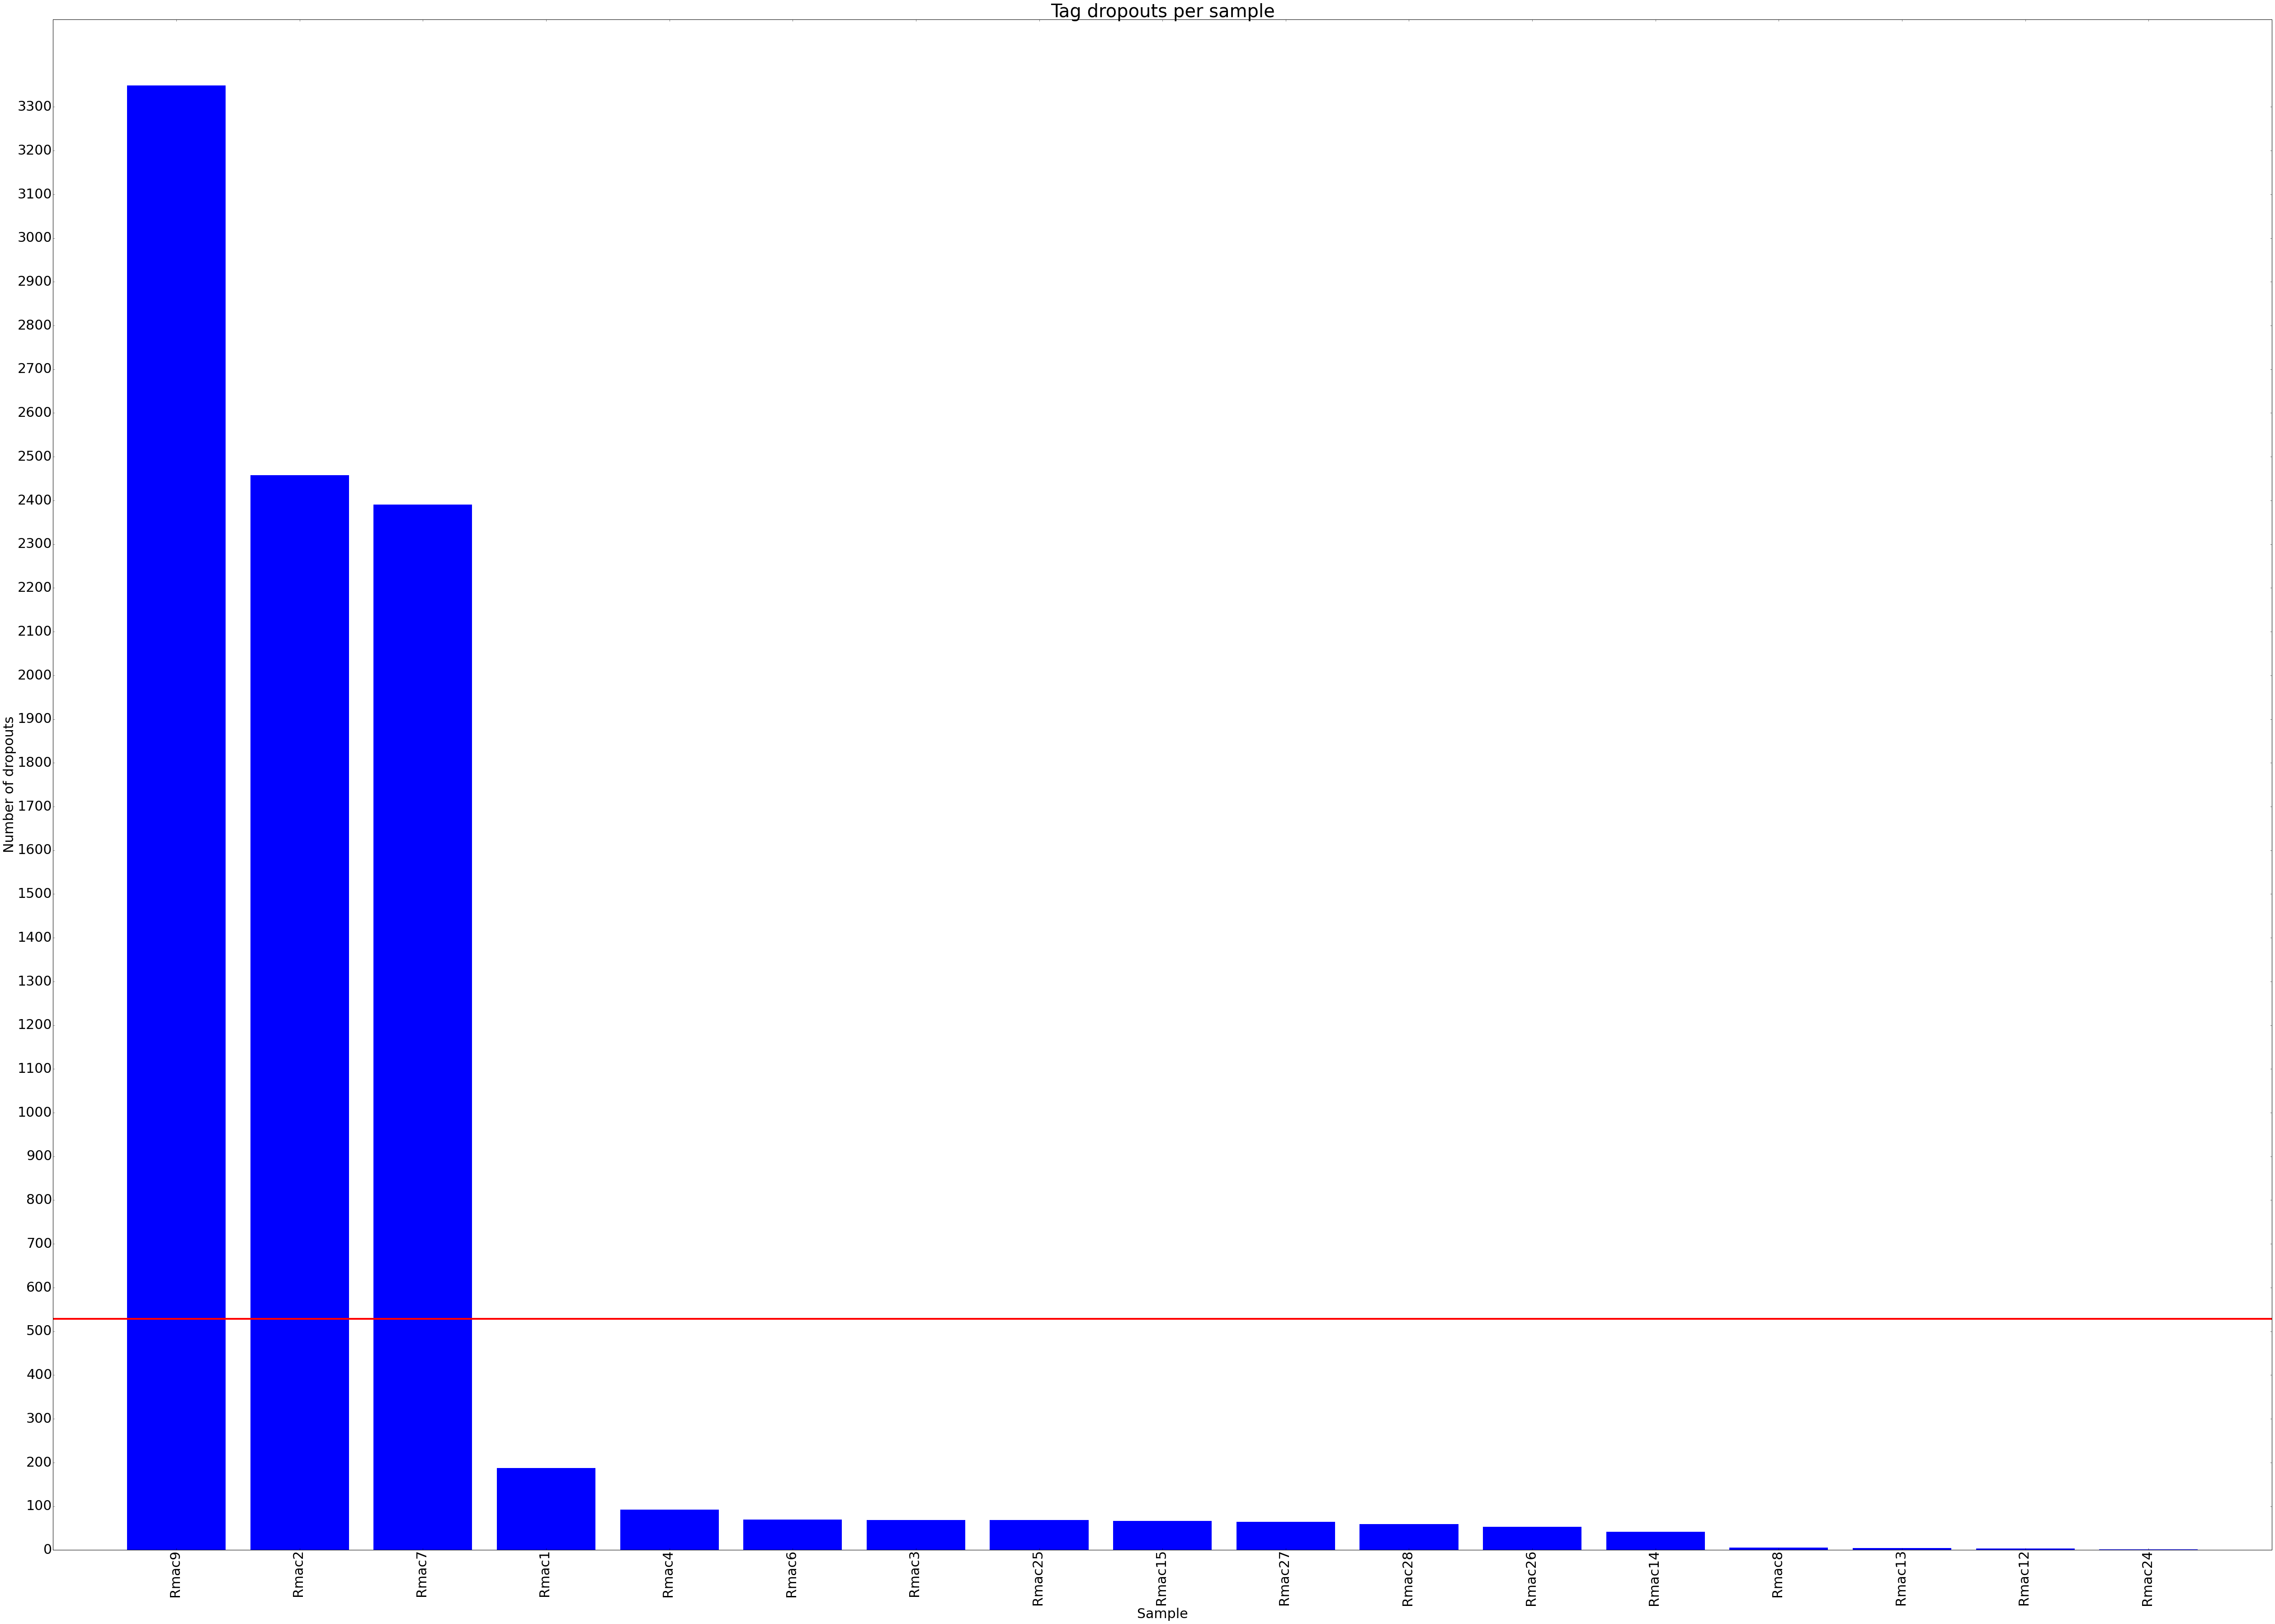

Outputs written to:
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//Tag_dropouts_per_sample.txt
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//Tag_dropouts_per_tag.txt
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//Tag_dropouts_per_sample.pdf
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//Tag_dropouts_per_tag.pdf
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//blacklist.txt


In [3]:
wd = "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all/"

blacklist = MISC.missing_data_finder("%s/batch_1.vcf" % wd, wd)

3 very bad samples here, 1 female and 2 male.

I will try to continue with them in, as this is a very small sample set already


### Now run a PCA to look at the structure in the data . . . 

In [4]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1_altered_adegenet_plink-temporary.fam
written.
3578 variants loaded from .bim file.
17 people (0 males, 0 female

In [6]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.txt")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 19.7 x 19.7 in image

  warnings.warn(x, RRuntimeWarning)


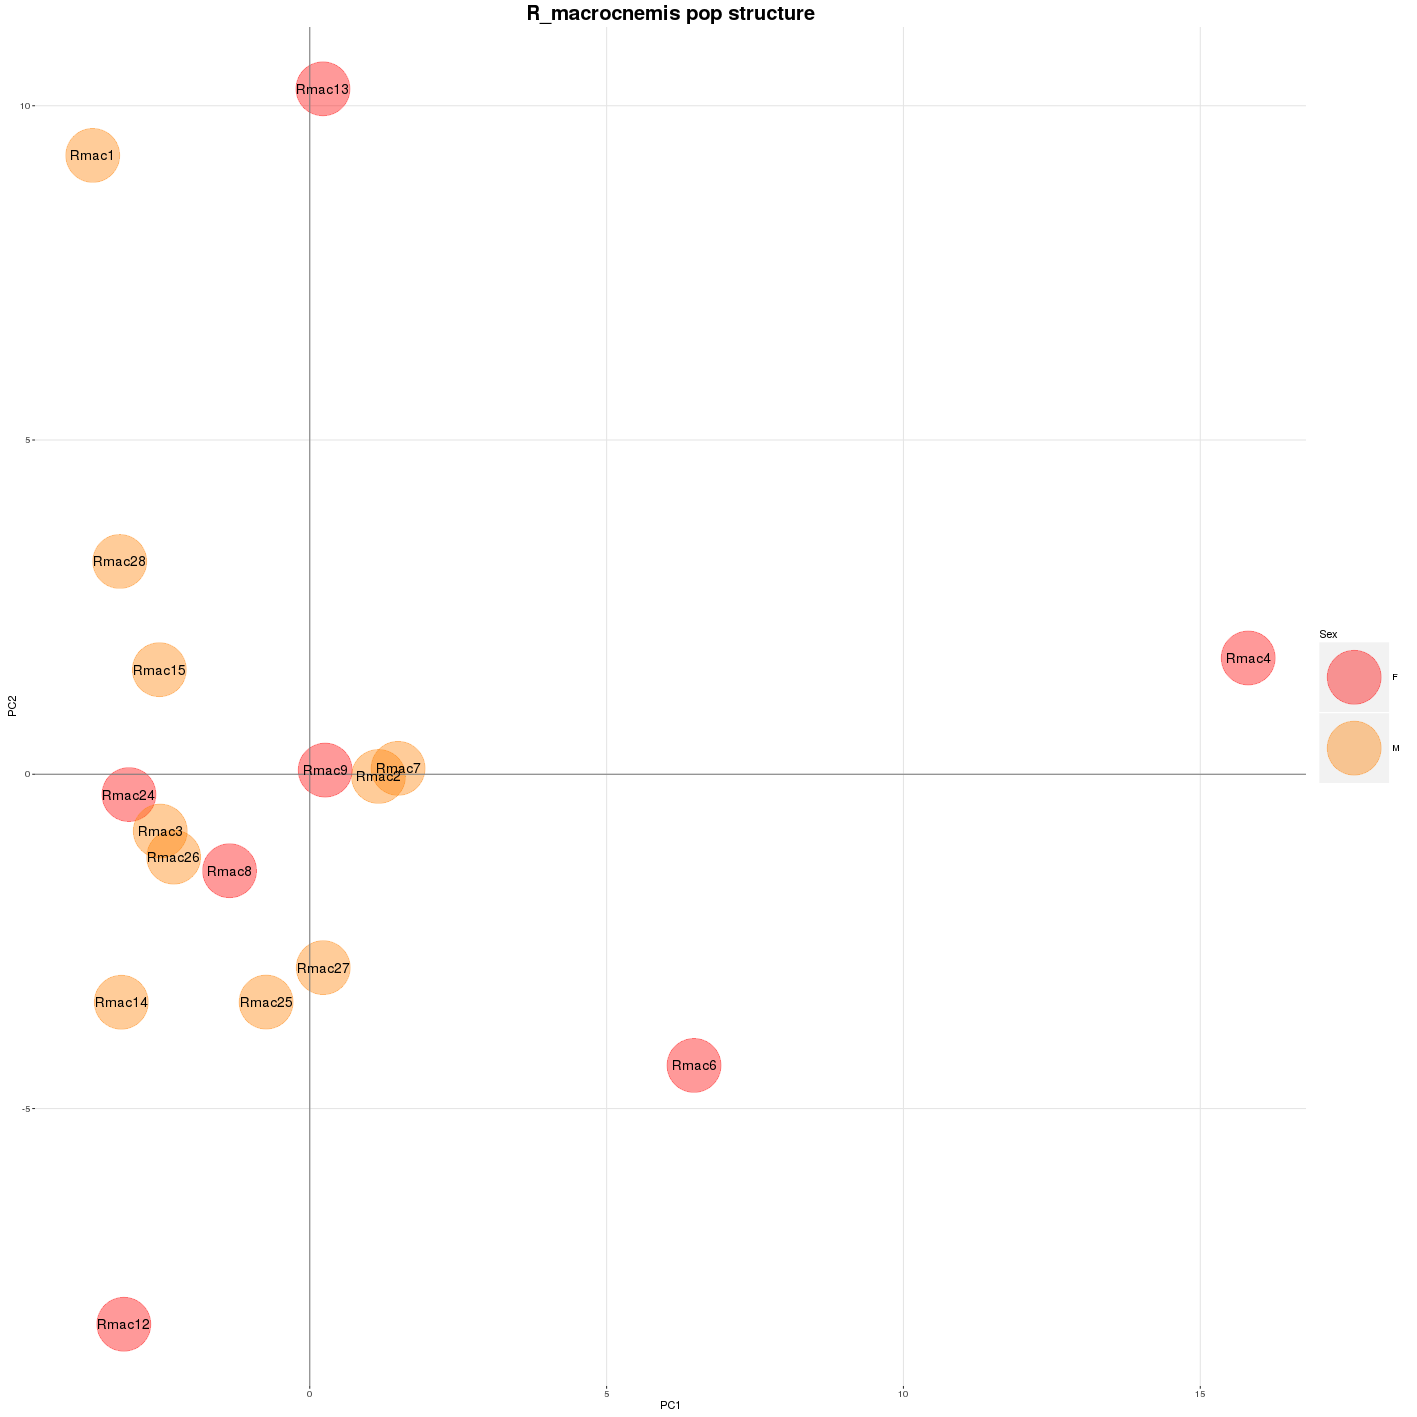

In [7]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_macrocnemis pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So there is some structure here, not ideal, but lets see what we get

Number of tags =  3578
Average tag coverage 33.0217012462 (+- 14.9617012428 )


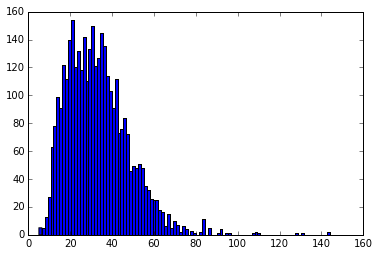

In [1]:
%matplotlib inline
import MISC_RAD_tools as MISC
wd = "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all/"
final_vcf = "%s/batch_1.vcf" % wd
MISC.av_tag_cov(final_vcf, "%s/Av_tag_cov.out" % wd)
#MISC.sample_Avcov_from_vcf(final_vcf)

In [10]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_all//batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 3578
Number of samples = 17
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 3577
Number of putative X linked snps = 14
Number of putative X linked tags = 14
Number of putative Z linked markers = 16
Number of putative Z linked tags = 16


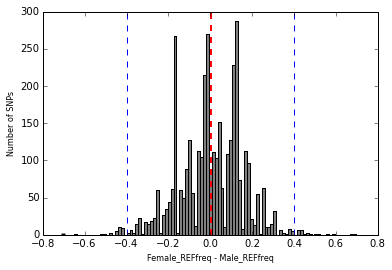


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 3578
Number of samples = 17
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 3577
Number of putative X linked snps = 11
Number of putative X linked tags = 11
Number of putative Z linked markers = 1
Number of putative Z linked tags = 1

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 7
Number of males: 10
Number of Putative Y linked tags: 342
Number of Putative W linked tags: 2

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 366
Final number of ZW tags = 19


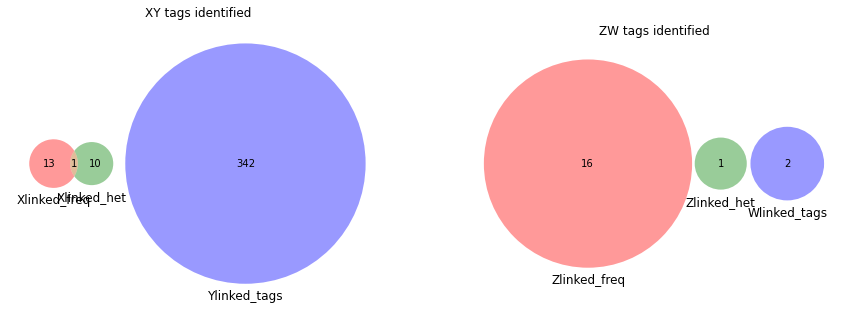

In [11]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

### Very strange result - I can't think of anything biological that would cause this. I will remove the 3 bad samples and try again. . . 


In [9]:
%%bash

wd=/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept//batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept//batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept//batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept//batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept//batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept//batch_1_altered_adegenet_plink-temporary.fam
written.
20314 variants loaded from .bim file.
14 people (0 males, 0

In [11]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("../sex_info_kept.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 19.7 x 19.7 in image

  warnings.warn(x, RRuntimeWarning)


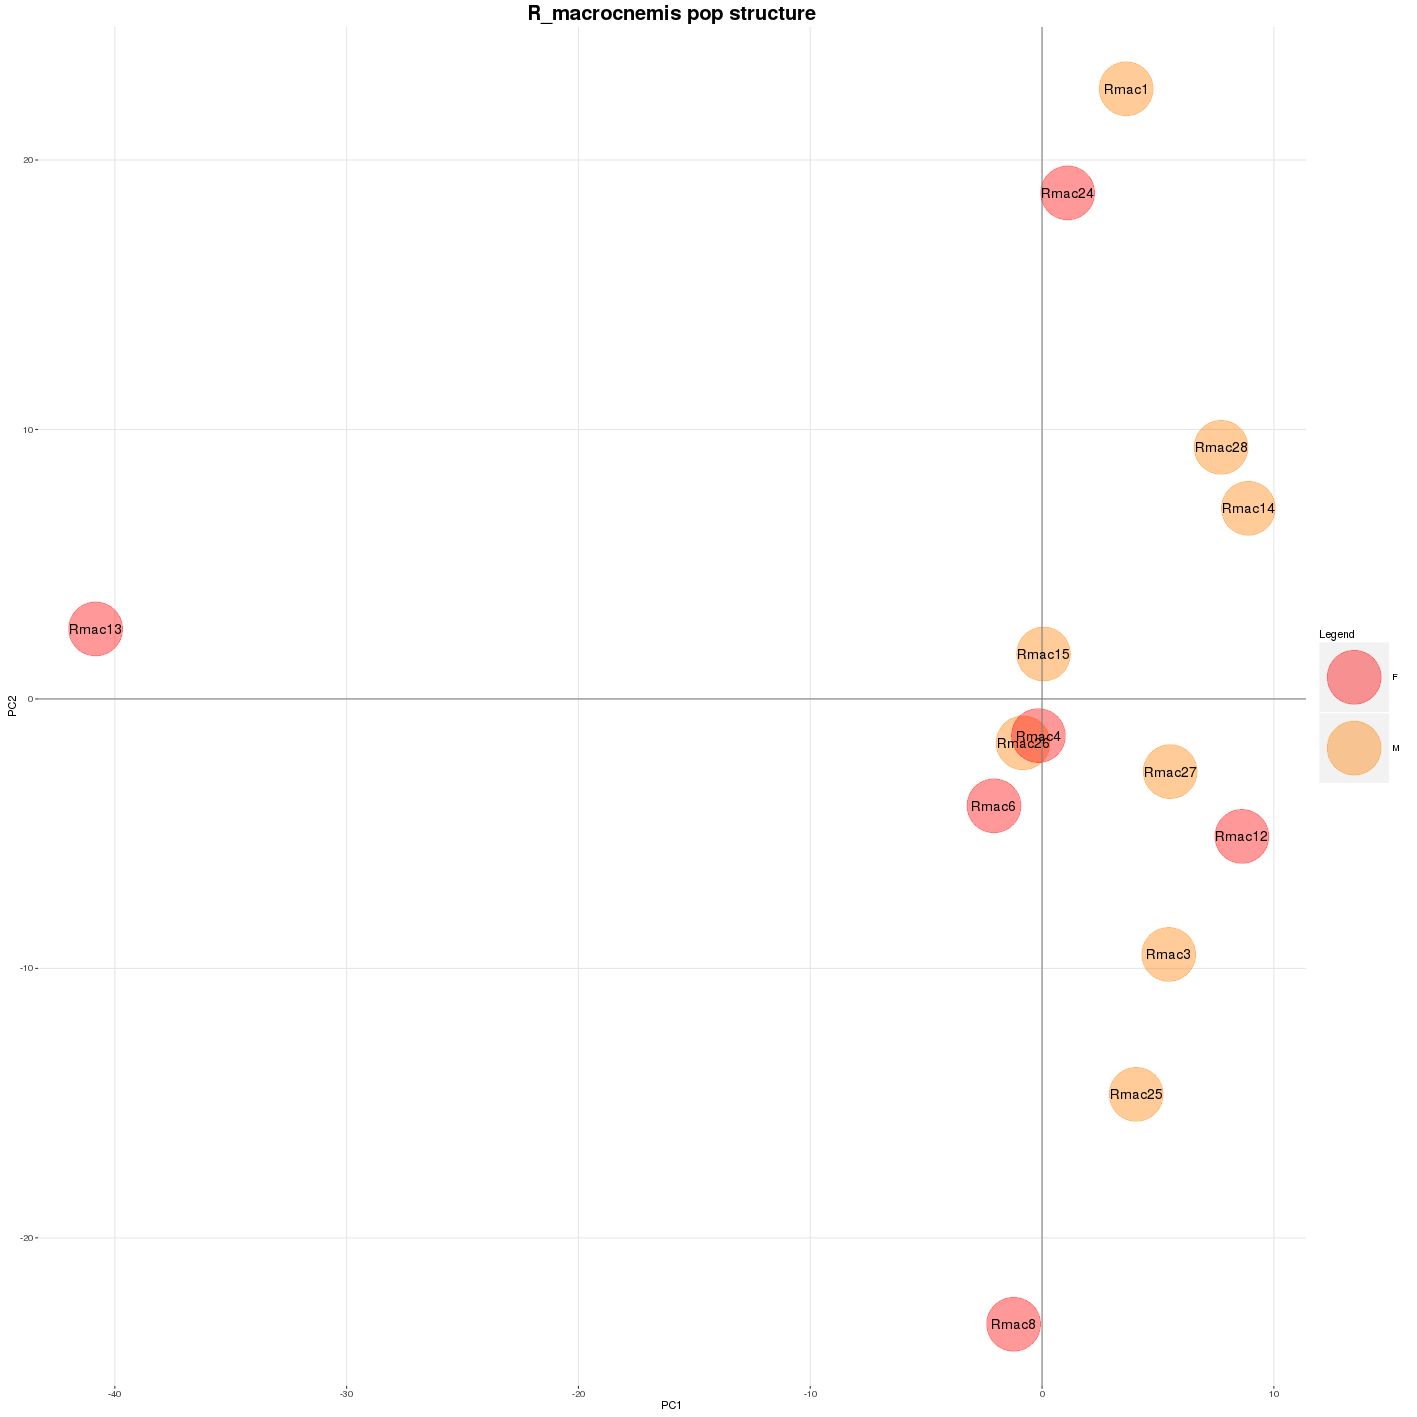

In [12]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R_macrocnemis pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [19]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Sex_ID_info_kept.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 6 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.75 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 20314
Number of samples = 14
Number of loci with too few samples = 6670
Number of loci with low MAF = 0
Number of loci with enough data = 13643
Number of putative X linked snps = 84
Number of putative X linked tags = 84
Number of putative Z linked markers = 43
Number of putative Z linked tags = 43


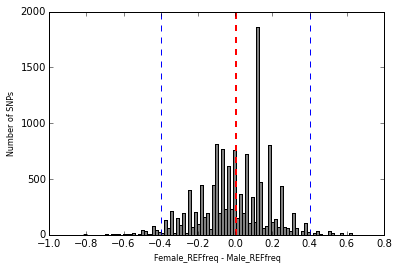


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 20314
Number of samples = 14
Number of loci with too few samples = 1805
Number of loci with low MAF = 0
Number of loci with enough data = 18508
Number of putative X linked snps = 113
Number of putative X linked tags = 113
Number of putative Z linked markers = 49
Number of putative Z linked tags = 49

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks

 ## After merging tags accross methods ## 

Final number of XY tags = 188
Final number of ZW tags = 88


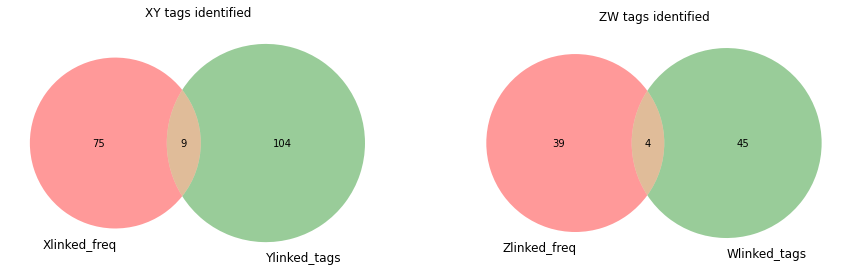

In [20]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "110")

This is not a great dataset at all, I think the 342 Y specific markers could be driven by the skew of samples towards males. Need more data to be sure. But can map them and see if they all map to the same chromosome. 

## Manual mapping

In [22]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
Rtemp_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"


best_hit_crit = 1e-3
Eval_threshold = 1e-15
Window = 10000

wd = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_macrocnemis/"
prefix = "R_mac"

### Tags to Rtemp

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_10000_chunks.fa"), Rtemp_blast_chunks)


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 28
Number of unique alingments kept: 20
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta . . . 
0 sequence scaffold segments are in /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_macrocnemis//blast_10000_chunks.fa


In [25]:
from collections import Counter

hits = []
for i in Rtemp_records:
    hits.append(Rtemp_records[i]["Ref_hit_id"].split("_")[1])
    
Counter(hits)

Counter({'Chr01': 10, 'Chr03': 7, 'Chr04': 6, 'Chr09': 4, 'Chr05': 4, 'Chr02': 4, 'Chr10': 3, 'Chr08': 3, 'Chr06': 3, 'C': 2, 'Chr07': 2})

In [21]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-3
Eval_threshold = 1e-15
Window = 10000

wd = "/home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_macrocnemis/"
prefix = "R_mac"

### Tags to Rtemp

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_10000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_10k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_10000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_10kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_10000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##



ApplicationError: Non-zero return code 2 from 'blastn -out /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_macrocnemis//R_mac_tags_Rtemp_blastnouts.xml -outfmt 5 -query /home/djeffrie/Data/Mapping_SL_tags_to_genomes/Sex_linked_tags/Manual_mapping/R_macrocnemis//Putative_XYlinked_makers.fa -db /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db', message 'BLAST Database error: No alias or index file found for nucleotide database [/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db] in search path [/home/djeffrie/Data/RADseq/Rmacrocnemis/Stacks/Populations_kept::]'